# 1. Stochastic Variational Inference in the TrueSkill Model

## Model definition

We assume that each player has a true, but unknown skill $z_i \in \mathbb{R}$.
We use $N$ to denote the number of players.

### The prior:
The prior over each player's skill is a standard normal distribution, and all player's skills are *a priori* independent.

### The likelihood:
For each observed game, the probability that player $i$ beats player $j$, given the player's skills $z_A$ and $z_B$, is:
$$p(A \,\, \text{beat} \,\, B | z_A, z_B) = \sigma(z_i - z_j)$$
where
$$\sigma(y) = \frac{1}{1 + \exp(-y)}$$
We chose this function simply because it's close to zero or one when the player's skills are very different, and equals one-half when the player skills are the same.  This likelihood function is the only thing that gives meaning to the latent skill variables $z_1 \dots z_N$.

There can be more than one game played between a pair of players. The outcome of each game is independent given the players' skills.
We use $M$ to denote the number of games.


In [ ]:
!pip install wget
import os
import os.path

import matplotlib.pyplot as plt
import wget

import pandas as pd


import numpy as np
from scipy.stats import norm
import scipy.io
import scipy.stats
import torch
import random
from torch import nn
from torch.distributions.normal import Normal

from functools import partial
from tqdm import trange, tqdm_notebook

import matplotlib.pyplot as plt

def diag_gaussian_log_density(x, mu, std):
    # axis=-1 means sum over the last dimension.
    m = Normal(mu, std)
    return torch.sum(m.log_prob(x), axis=-1)

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=1e7e67d52075a20529097a58ea41213a2aeb9f6494ba742e0a94990dc44df35d
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


## Implementing the TrueSkill Model



**a)** The function $\texttt{log_joint_prior}$ computes the log of the prior, jointly evaluated over all player's skills.

In [ ]:
def log_joint_prior(zs_array):
    return diag_gaussian_log_density(zs_array, torch.tensor([0.0]), torch.tensor([1.0]))

**b)** The function `logp_a_beats_b` that, given a pair of skills $z_a$ and $z_b$, evaluates the log-likelihood that player with skill $z_a$ beat player with skill $z_b$ under the model detailed above.


In [ ]:
def logp_a_beats_b(z_a, z_b):
    return -torch.logaddexp(torch.tensor([0.0]), z_b - z_a)

def log_prior_over_2_players(z1, z2):
    m = Normal(torch.tensor([0.0]), torch.tensor([[1.0]]))
    return m.log_prob(z1) + m.log_prob(z2)

def prior_over_2_players(z1, z2):
    return torch.exp(log_prior_over_2_players(z1, z2))

def log_posterior_A_beat_B(z1, z2):
    return log_prior_over_2_players(z1, z2) + logp_a_beats_b(z1, z2)

def posterior_A_beat_B(z1, z2):
    return torch.exp(log_posterior_A_beat_B(z1, z2))

def log_posterior_A_beat_B_20_times(z1, z2):
    return log_prior_over_2_players(z1, z2) + 20.0 * logp_a_beats_b(z1, z2)

def posterior_A_beat_B_20_times(z1, z2):
    return torch.exp(log_posterior_A_beat_B_20_times(z1, z2))

def log_posterior_beat_each_other_20_times(z1, z2):
    return log_prior_over_2_players(z1, z2) \
        + 20.* logp_a_beats_b(z1, z2) \
        + 20.* logp_a_beats_b(z2, z1)

def posterior_beat_each_other_20_times(z1, z2):
    return torch.exp(log_posterior_beat_each_other_20_times(z1, z2))

In [ ]:
def plot_isocontours(ax, func, xlimits=[-4, 4], ylimits=[-4, 4], steps=101, cmap="summer"):
    x = torch.linspace(*xlimits, steps=steps)
    y = torch.linspace(*ylimits, steps=steps)
    X, Y = torch.meshgrid(x, y)
    Z = func(X, Y)
    plt.contour(X, Y, Z, cmap=cmap)
    ax.set_yticks([])
    ax.set_xticks([])

def plot_2d_fun(f, x_axis_label="", y_axis_label="", f2=None, scatter_pts=None):
    fig = plt.figure(figsize=(8,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    plot_isocontours(ax, f)
    if f2 is not None:
      plot_isocontours(ax, f2, cmap='winter')

    if scatter_pts is not None:
      plt.scatter(scatter_pts[:,0], scatter_pts[:, 1])
    plt.plot([4, -4], [4, -4], 'b--')   # Line of equal skill
    plt.show(block=True)
    plt.draw()

## 1.1 Stochastic Variational Inference on Two Players


**a)** Evidence lower bound function and reparameterized sampler for the approximate posterior.

In [ ]:
def diag_gaussian_samples(mean, log_std, num_samples):
    # mean and log_std are (D) dimensional vectors
    sigma = torch.exp(log_std)
    return mean + sigma * torch.randn(num_samples, mean.shape[-1])


def diag_gaussian_logpdf(x, mean, log_std):
    return diag_gaussian_log_density(x, mean, torch.exp(log_std))


def batch_elbo(logprob, mean, log_std, num_samples):
    sample = diag_gaussian_samples(mean, log_std, num_samples)
    entropy = - diag_gaussian_logpdf(sample, mean, log_std)
    return torch.mean(logprob(sample) + entropy)


In [ ]:
# Hyperparameters
num_players = 2
n_iters = 1200
stepsize = 0.0001
num_samples_per_iter = 80

def log_posterior_A_beat_B_20_times_1_arg(z1z2):
  return log_posterior_A_beat_B_20_times(z1z2[:,0], z1z2[:,1]).flatten()

def objective(params):  # The loss function to be minimized.
  return - batch_elbo(log_posterior_A_beat_B_20_times_1_arg, params[0], \
            params[1], num_samples_per_iter)


**c)** Initialize a set of variational parameters and optimize them to approximate the joint where we observe player A winning 20 games.

Optimizing variational parameters...


  1%|          | 8/1200 [00:00<00:15, 79.42it/s]

Iteration 0 lower bound 21.582189559936523
Iteration 25 lower bound 15.530644416809082
Iteration 50 lower bound 10.002942085266113


  5%|▍         | 57/1200 [00:00<00:03, 316.02it/s]

Iteration 75 lower bound 8.26392650604248


 12%|█▏        | 149/1200 [00:00<00:02, 415.54it/s]

Iteration 100 lower bound 6.761476993560791
Iteration 125 lower bound 5.49306583404541
Iteration 150 lower bound 5.517738342285156


 17%|█▋        | 203/1200 [00:00<00:02, 457.26it/s]

Iteration 175 lower bound 4.829862594604492
Iteration 200 lower bound 4.6099629402160645


 21%|██▏       | 257/1200 [00:00<00:01, 482.57it/s]

Iteration 225 lower bound 4.656652927398682
Iteration 250 lower bound 4.24110221862793
Iteration 275 lower bound 4.202141761779785


 26%|██▌       | 307/1200 [00:00<00:01, 486.85it/s]

Iteration 300 lower bound 4.146100044250488
Iteration 325 lower bound 4.019158840179443


 30%|██▉       | 358/1200 [00:00<00:01, 493.48it/s]

Iteration 350 lower bound 4.010607719421387
Iteration 375 lower bound 4.1698102951049805


 34%|███▍      | 408/1200 [00:00<00:01, 481.00it/s]

Iteration 400 lower bound 4.001795768737793
Iteration 425 lower bound 3.8075592517852783


 38%|███▊      | 462/1200 [00:01<00:01, 498.13it/s]

Iteration 450 lower bound 4.299984931945801
Iteration 475 lower bound 3.8866171836853027
Iteration 500 lower bound 3.876803159713745


 43%|████▎     | 516/1200 [00:01<00:01, 509.09it/s]

Iteration 525 lower bound 3.9580016136169434
Iteration 550 lower bound 3.8875420093536377


 52%|█████▏    | 620/1200 [00:01<00:01, 512.97it/s]

Iteration 575 lower bound 4.06904935836792
Iteration 600 lower bound 3.8707003593444824
Iteration 625 lower bound 3.949465274810791


 56%|█████▌    | 672/1200 [00:01<00:01, 497.90it/s]

Iteration 650 lower bound 3.950709819793701


 60%|██████    | 725/1200 [00:01<00:00, 506.31it/s]

Iteration 675 lower bound 4.05858039855957
Iteration 700 lower bound 3.986579418182373
Iteration 725 lower bound 4.032863616943359
Iteration 750 lower bound 3.9358150959014893


 65%|██████▍   | 776/1200 [00:01<00:00, 502.44it/s]

Iteration 775 lower bound 3.9693450927734375


 69%|██████▉   | 827/1200 [00:01<00:00, 503.12it/s]

Iteration 800 lower bound 4.107428550720215
Iteration 825 lower bound 3.9436028003692627
Iteration 850 lower bound 4.006807804107666


 73%|███████▎  | 878/1200 [00:01<00:00, 487.29it/s]

Iteration 875 lower bound 4.08346700668335


 77%|███████▋  | 927/1200 [00:01<00:00, 477.11it/s]

Iteration 900 lower bound 3.8710620403289795
Iteration 925 lower bound 3.963590145111084
Iteration 950 lower bound 3.9546046257019043
Iteration 975 lower bound 3.8781962394714355


 82%|████████▏ | 981/1200 [00:02<00:00, 493.00it/s]

Iteration 1000 lower bound 4.056523323059082


 90%|█████████ | 1083/1200 [00:02<00:00, 489.38it/s]

Iteration 1025 lower bound 3.945901393890381
Iteration 1050 lower bound 3.9764180183410645
Iteration 1075 lower bound 4.002940654754639
Iteration 1100 lower bound 3.859714984893799


100%|██████████| 1200/1200 [00:02<00:00, 478.24it/s]

Iteration 1125 lower bound 4.007403373718262
Iteration 1150 lower bound 3.940152645111084
Iteration 1175 lower bound 3.962249279022217



/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


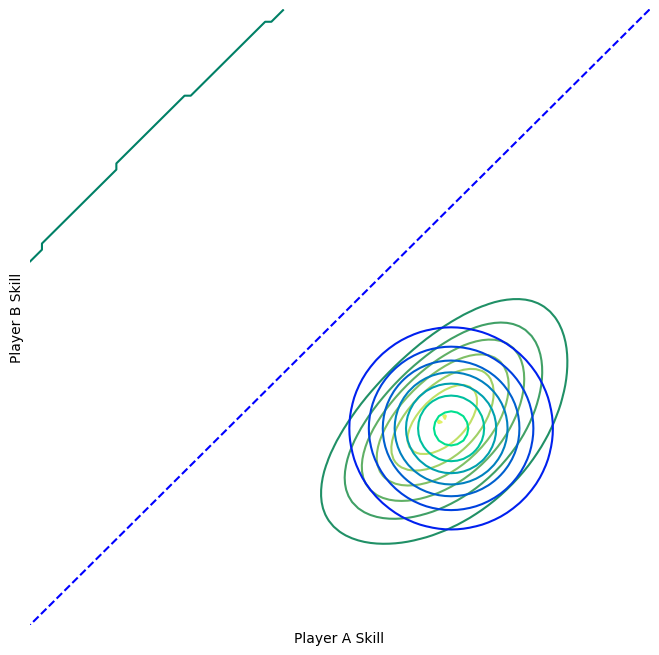

Final loss: 3.919434070587158


<Figure size 640x480 with 0 Axes>

In [ ]:
def callback(params, t):
  if t % 25 == 0:
    print("Iteration {} lower bound {}".format(t, objective(params)))

# Set up optimizer.
D = 2
init_log_std = torch.zeros(D, requires_grad=True)
init_mean = torch.zeros(D, requires_grad=True)


params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

def update():
    optimizer.zero_grad()
    loss = objective(params)
    loss.backward()
    optimizer.step()

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)


def approx_posterior_2d(z1, z2):
    # The approximate posterior
    mean, logstd = params[0].detach(), params[1].detach()
    return torch.exp(diag_gaussian_logpdf(torch.stack([z1, z2], dim=2), mean, logstd))

plot_2d_fun(posterior_A_beat_B_20_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d)

# final loss
print("Final loss: {}".format(objective(params)))

**d)** Loss function called $\texttt{objective}$  that takes variational distribution parameters , and returns a negative elbo estimate using simple Monte carlo with $\texttt{num_samples_per_iter}$ samples, to approximate the joint where we observe player A winning 20 games and player B winning 20 games.


In [ ]:
# Hyperparameters
n_iters = 100
stepsize = 0.0001
num_samples_per_iter = 50

def log_posterior_beat_each_other_20_times_1_arg(z1z2):
    # z1z2 is a tensor with shape (num_samples x 2)
    return log_posterior_beat_each_other_20_times(z1z2[:,0], z1z2[:,1]).flatten()


def objective(params):
  return - batch_elbo(log_posterior_beat_each_other_20_times_1_arg, \
            params[0], params[1], num_samples_per_iter)

Optimizing variational parameters...


 34%|███▍      | 34/100 [00:00<00:00, 336.60it/s]

Iteration 0 lower bound 64.31440734863281
Iteration 25 lower bound 47.202396392822266
Iteration 50 lower bound 40.43796157836914
Iteration 75 lower bound 34.714046478271484


100%|██████████| 100/100 [00:00<00:00, 399.64it/s]


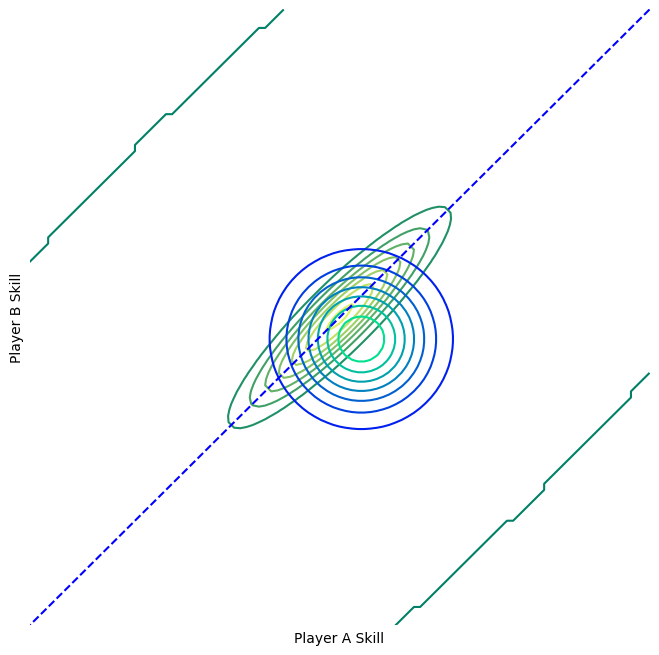

Final loss: 33.588722229003906


<Figure size 640x480 with 0 Axes>

In [ ]:
# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)

plot_2d_fun(posterior_beat_each_other_20_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d)

# final loss
print("Final loss: {}".format(objective(params)))

## 1.2 Approximate inference

The dataset contains data on 2500 games amongst 33 Premier League teams:
 - names is a 33 by 1 matrix, whose $i$’th entry is the name of player $i$.
 - games is a 2500 by 2 matrix of game outcomes, one row per game.

The first column contains the indices of the team who won.
The second column contains the indices of the team who lost.

It is based on the following kaggle dataset: https://www.kaggle.com/datasets/evangower/premier-league-matches-19922022

<!-- The dataset contains data on 2546 chess games amongst 1434 players:
 - names is a 1434 by 1 matrix, whose $i$’th entry is the name of player $i$.
 - games is a 2546 by 2 matrix of game outcomes (actually chess matches), one row per game.

The first column contains the indices of the players who won.
The second column contains the indices of the player who lost.

It is based on the kaggle chess dataset: https://www.kaggle.com/datasets/datasnaek/chess -->




In [ ]:
# Download the dataset
!curl -L -o premier-league-matches-19922022.zip\
  https://www.kaggle.com/api/v1/datasets/download/evangower/premier-league-matches-19922022
!unzip premier-league-matches-19922022.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 81859  100 81859    0     0   150k      0 --:--:-- --:--:-- --:--:-- 1737k
Archive:  premier-league-matches-19922022.zip
  inflating: premier-league-matches.csv  


In [ ]:
from sklearn.preprocessing import LabelEncoder

def load_games():
    dataset = pd.read_csv("premier-league-matches.csv")
    mini_ds = dataset[dataset['FTR'] != 'D'][-2500:]
    all_teams = pd.concat((mini_ds['Home'], mini_ds['Away'])).unique()
    encoder = LabelEncoder()
    encoder.fit(all_teams)
    mini_ds['HomeId'] = encoder.transform(mini_ds['Home'])
    mini_ds['AwayId'] = encoder.transform(mini_ds['Away'])

    winner_ids = np.where(mini_ds['FTR'] == 'H', mini_ds['HomeId'], mini_ds['AwayId'])
    loser_ids = np.where(mini_ds['FTR'] == 'H', mini_ds['AwayId'], mini_ds['HomeId'])
    games = np.column_stack((winner_ids, loser_ids))
    names = encoder.classes_

    return games, names

games, names = load_games()
games = torch.LongTensor(games)

In [ ]:
def log_games_likelihood(zs, games):
    winning_player_ixs = games[:,0]
    losing_player_ixs = games[:,1]

    winning_player_skills = zs[:, winning_player_ixs]
    losing_player_skills = zs[:, losing_player_ixs]

    log_likelihoods = logp_a_beats_b(winning_player_skills, losing_player_skills)
    return torch.sum(log_likelihoods, dim=1)

In [ ]:
def log_joint_probability(zs):
    return log_joint_prior(zs) + log_games_likelihood(zs, games)

In [ ]:
# Hyperparameters
num_players = 33
n_iters = 200
stepsize = 0.0001
num_samples_per_iter = 50

def objective(params): # ojective function
  return - batch_elbo(log_joint_probability, params[0], \
            params[1], num_samples_per_iter)


Optimization and final loss report

In [ ]:
# Set up optimizer.
init_mean = torch.zeros(num_players, requires_grad=True)
init_log_std  = torch.zeros(num_players, requires_grad=True)
params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

def update():
    optimizer.zero_grad()
    loss = objective(params)
    loss.backward()
    optimizer.step()

# Optimize and print loss in a loop
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)
print("Final loss: {}".format(objective(params)))

Optimizing variational parameters...


  5%|▌         | 10/200 [00:00<00:02, 94.84it/s]

Iteration 0 lower bound 2224.9560546875


 24%|██▍       | 49/200 [00:00<00:01, 124.02it/s]

Iteration 25 lower bound 1688.42138671875
Iteration 50 lower bound 1585.282958984375


 48%|████▊     | 95/200 [00:00<00:00, 144.49it/s]

Iteration 75 lower bound 1555.917236328125


 55%|█████▌    | 110/200 [00:01<00:01, 87.17it/s]

Iteration 100 lower bound 1536.478271484375


 66%|██████▋   | 133/200 [00:01<00:00, 79.66it/s]

Iteration 125 lower bound 1531.810302734375


 80%|████████  | 161/200 [00:01<00:00, 71.36it/s]

Iteration 150 lower bound 1526.0623779296875


 94%|█████████▍| 188/200 [00:02<00:00, 72.63it/s]

Iteration 175 lower bound 1522.224853515625


100%|██████████| 200/200 [00:02<00:00, 81.15it/s]

Final loss: 1519.425048828125


final loss is 1519.425048828125.

Plot the approximate mean and variance of all players, sorted by skill.

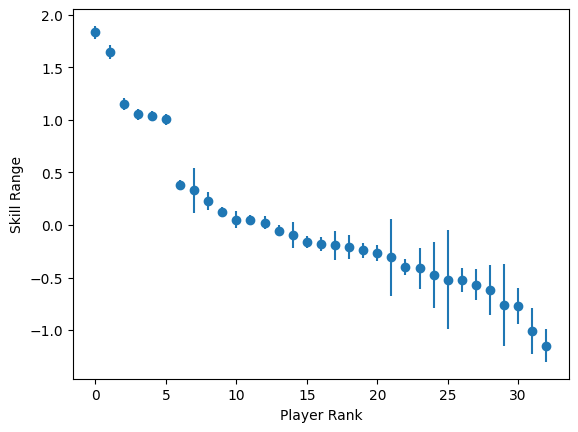

In [ ]:
mean_skills = params[0].detach()
logstd_skills = params[1].detach()
var_skills = torch.exp(2 * logstd_skills)
ordered_mean = mean_skills[torch.argsort(mean_skills, descending=True)]
ordered_var = var_skills[torch.argsort(mean_skills, descending=True)]

# descending sort: small rank index indicates higher skill
plt.errorbar(range(len(ordered_mean)), ordered_mean,
             yerr=ordered_var, fmt='o')
plt.xlabel("Player Rank")
plt.ylabel("Skill Range")
plt.show()

 The exact probability under a factorized Gaussian over two players’ skills that one has higher skill than the other.


Assume:
$$\begin{bmatrix}z_A\\z_B\end{bmatrix}\sim \mathcal{N}(\begin{bmatrix}\mu_A\\\mu_B\end{bmatrix}, \ \begin{bmatrix}\sigma_A^2 & 0\\ 0 & \sigma_B^2\end{bmatrix})$$ \
By hint 1:
$$\begin{bmatrix}y_A\\y_B\end{bmatrix}=\begin{bmatrix}z_A-z_B\\z_B\end{bmatrix}=\begin{bmatrix}1 & -1\\ 0 & 1\end{bmatrix}\begin{bmatrix}z_A\\z_B\end{bmatrix}\triangleq A\begin{bmatrix}z_A\\z_B\end{bmatrix}$$ \
By hint 2:
$$\begin{bmatrix}y_A\\y_B\end{bmatrix}=\begin{bmatrix}z_A-z_B\\z_B\end{bmatrix} \sim \mathcal{N}(A\begin{bmatrix}\mu_A\\ \mu_B\end{bmatrix}, A\begin{bmatrix}\sigma_A^2 & 0\\ 0 & \sigma_B^2\end{bmatrix}A^T)$$ \
Namely:
$$\begin{bmatrix}y_A\\y_B\end{bmatrix} \sim \mathcal{N}(\begin{bmatrix}1 & -1\\ 0 & 1\end{bmatrix}\begin{bmatrix}\mu_A\\ \mu_B\end{bmatrix}, \begin{bmatrix}1 & -1\\ 0 & 1\end{bmatrix}\begin{bmatrix}\sigma_A^2 & 0\\ 0 & \sigma_B^2\end{bmatrix}\begin{bmatrix}1 & 0\\ -1 & 1\end{bmatrix})$$
Simplify to get:
$$\begin{bmatrix}y_A\\y_B\end{bmatrix}\sim \mathcal{N}(\begin{bmatrix}\mu_A-\mu_B\\\mu_B\end{bmatrix}, \ \begin{bmatrix}\sigma_A^2 + \sigma_B^2 & -\sigma_B^2\\ -\sigma_B^2 & \sigma_B^2\end{bmatrix})$$
By hint 3:
$$y_A \sim \mathcal{N}(\mu_a-\mu_B, \sigma_A^2 + \sigma_B^2)$$
Thus using symmetry of standard gaussian distribution:
$$P(z_A>z_B)=P(z_A-z_B>0)=P(y_A>0)=P(\frac{y_A-(\mu_A-\mu_B)}{\sqrt{\sigma_A^2+\sigma_B^2}}>\frac{0-(\mu_A-\mu_B)}{\sqrt{\sigma_A^2+\sigma_B^2}})=P(Z>\frac{-(\mu_A-\mu_B)}{\sqrt{\sigma_A^2+\sigma_B^2}})=P(Z\leq \frac{\mu_A-\mu_B}{\sqrt{\sigma_A^2+\sigma_B^2}})\triangleq 𝚽(\frac{\mu_A-\mu_B}{\sqrt{\sigma_A^2+\sigma_B^2}}),$$
such that $Z\sim \mathcal{N}(0,1)$ and $𝚽(⋅)$ is the CDF of $Z$.


# 2. VAE with synthetic data

Function below generates the synthetic knot shape data.

In [ ]:
def make_banana_data(num_classes, num_per_class, noise_std=0.3):
    # Create points in the shape of a banana
    features = []
    labels = []

    for i in range(num_classes):
        theta = torch.linspace(0, np.pi, num_per_class) + i * (2 * np.pi / num_classes)  # spread across the circle
        x = torch.sin(theta) + noise_std * torch.randn_like(theta)  # add some noise
        y = torch.cos(theta) * (torch.sin(theta) + noise_std * torch.randn_like(theta))  # banana shape, noise too

        features.append(torch.stack([x, y], dim=1))
        labels.extend([i] * num_per_class)

    # Concatenate features and labels
    features = torch.cat(features, dim=0)
    labels = torch.tensor(labels).long()

    # Shuffle the dataset
    perm_ix = torch.randperm(labels.shape[0])
    return labels[perm_ix], features[perm_ix]

We visualize the 2d data generated from the above function. Notice that there are 3 clusters in the input space, each colored with a different color. The VAE will not see the cluster assignments, but we hope to recover this structure in the latent space.

(-1.1488386392593384,
 1.1407054662704468,
 -0.5850600868463516,
 0.5882399350404739)

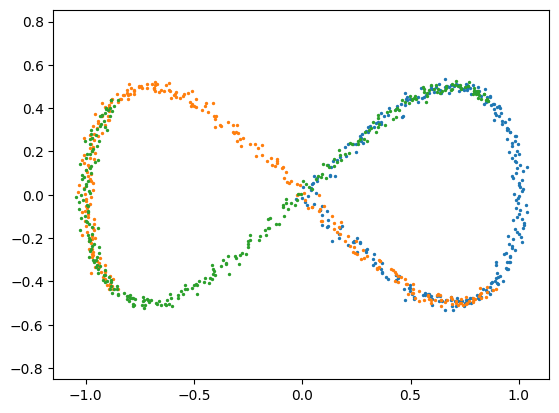

In [ ]:
num_clusters = 3
samples_per_cluster = 300
labels, data = make_banana_data(num_clusters, samples_per_cluster, 0.02)


for k in range(num_clusters):
    plt.scatter(data[labels == k, 0], data[labels == k, 1], s=2)

plt.axis("equal")

## 2.1 $\texttt{elbo}$ function for a variational autoencoder.


In [ ]:
# Generic VAE functions.

def log_prior(zs_array):
    return diag_gaussian_log_density(zs_array, torch.tensor([0.0]), torch.tensor([1.0]))

def diag_gaussian_samples(mean, log_std, num_samples):
    return mean + torch.exp(log_std) * torch.randn(num_samples, mean.shape[-1])

def diag_gaussian_logpdf(x, mean, log_std):
    return diag_gaussian_log_density(x, mean, torch.exp(log_std))


def batch_elbo(  # Simple Monte Carlo estimate of the variational lower bound.
    recognition_net,    # takes a batch of datapoints, outputs mean and log_std of size (batch_size x latent_dim), i.e. log q(z|x)
    decoder_net,        # takes a batch of latent samples, outputs mean and log_std of size (batch_size x data_dim), i.e. log p(x|z)
    log_joint,          # takes decoder_net, a batch of latent samples, and a batch of datapoints, outputs unnormalized log joint, i.e. log p(x,z)
    data                # a.k.a. x
    ):

    mean = recognition_net(data)[0]
    log_std = recognition_net(data)[1]
    sample = diag_gaussian_samples(mean, log_std, len(data))
    log_joint_res = log_joint(decoder_net, sample, data)
    log_posterior_res = diag_gaussian_logpdf(sample, mean, log_std)
    return torch.mean(log_joint_res - log_posterior_res)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

data_dimension = 2
latent_dimension = 2

# Define the recognition network.
class RecognitionNet(nn.Module):
    def __init__(self, data_dimension, latent_dimension):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(data_dimension, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU()
        )
        self.mean_net = nn.Linear(50, latent_dimension) # Output mean of q(z)
        self.std_net = nn.Linear(50, latent_dimension) # Output log_std of q(z)

    def forward(self, x):
        interm = self.net(x)
        mean, log_std = self.mean_net(interm), self.std_net(interm)
        return mean, log_std

recognition_net = RecognitionNet(data_dimension, latent_dimension)

# Define the decoder network.
class Decoder(nn.Module):
    def __init__(self, latent_dimension, data_dimension):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dimension, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU()
        )
        self.mean_net = nn.Linear(50, data_dimension) # Output mean of p(x|z)
        self.std_net = nn.Linear(50, data_dimension) # Output log_std of p(x|z)

    def forward(self, x):
        interm = self.net(x)
        mean, log_std = self.mean_net(interm), self.std_net(interm)
        return mean, log_std

decoder_net = Decoder(latent_dimension, data_dimension)

# Set up log likelihood function.
def log_likelihood(decoder_net, latent, data):
    mean, log_std = decoder_net(latent)
    return diag_gaussian_logpdf(data, mean,
                                np.log(0.1) + 0. * log_std)

def log_joint(decoder_net, latent, data):
    return log_prior(latent) + log_likelihood(decoder_net, latent, data)

# Run optimization
optimizer = torch.optim.Adam([{'params': recognition_net.parameters()},
                      {'params': decoder_net.parameters()}], lr=1e-3)
n_iters = 2000
minibatch_size = 300

dataset = TensorDataset(torch.tensor(data))
dataloader = DataLoader(dataset, batch_size=minibatch_size, shuffle=True)

def objective(recognition_net, decoder_net):  # The loss function to be minimized.
    minibatch = next(iter(dataloader))[0]
    return -batch_elbo(
    recognition_net,
    decoder_net,
    log_joint,
    minibatch)

def callback(t):
    if t % 100 == 0:
        print("Iteration {} lower bound {}".format(t, -objective(recognition_net, decoder_net)))

def update():
    optimizer.zero_grad()
    loss = objective(recognition_net, decoder_net)
    loss.backward()
    optimizer.step()

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(t)

<ipython-input-29-26fe4ed13568>:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(data))


Optimizing variational parameters...


  0%|          | 2/2000 [00:00<01:42, 19.44it/s]

Iteration 0 lower bound -29.6019344329834


  6%|▌         | 111/2000 [00:01<00:21, 86.64it/s]

Iteration 100 lower bound -11.872624397277832


 11%|█         | 223/2000 [00:02<00:18, 95.66it/s]

Iteration 200 lower bound -1.9329372644424438


 16%|█▌        | 313/2000 [00:03<00:15, 106.51it/s]

Iteration 300 lower bound -1.3501286506652832


 21%|██        | 415/2000 [00:04<00:13, 117.29it/s]

Iteration 400 lower bound -1.14596688747406


 26%|██▌       | 519/2000 [00:05<00:12, 114.95it/s]

Iteration 500 lower bound -0.9888425469398499


 31%|███       | 624/2000 [00:06<00:11, 123.94it/s]

Iteration 600 lower bound -0.9580217599868774


 36%|███▌      | 715/2000 [00:06<00:10, 121.17it/s]

Iteration 700 lower bound -1.0008183717727661


 41%|████      | 816/2000 [00:07<00:09, 119.78it/s]

Iteration 800 lower bound -0.8244034647941589


 46%|████▌     | 919/2000 [00:08<00:09, 118.71it/s]

Iteration 900 lower bound -0.8714150190353394


 51%|█████     | 1023/2000 [00:09<00:08, 114.99it/s]

Iteration 1000 lower bound -0.8478409647941589


 56%|█████▌    | 1114/2000 [00:10<00:07, 124.55it/s]

Iteration 1100 lower bound -0.7896232604980469


 60%|█████▉    | 1192/2000 [00:10<00:06, 121.45it/s]

Iteration 1200 lower bound -0.8172414898872375


 66%|██████▌   | 1319/2000 [00:12<00:05, 118.29it/s]

Iteration 1300 lower bound -0.8088454008102417


 71%|███████   | 1415/2000 [00:13<00:06, 91.45it/s]

Iteration 1400 lower bound -0.7943127155303955


 76%|███████▌  | 1518/2000 [00:14<00:05, 88.10it/s]

Iteration 1500 lower bound -0.7574678659439087


 81%|████████  | 1623/2000 [00:15<00:03, 100.48it/s]

Iteration 1600 lower bound -0.7147595286369324


 86%|████████▌ | 1721/2000 [00:16<00:02, 113.58it/s]

Iteration 1700 lower bound -0.7830201983451843


 91%|█████████ | 1820/2000 [00:17<00:01, 116.13it/s]

Iteration 1800 lower bound -0.8669112920761108


 96%|█████████▌| 1923/2000 [00:18<00:00, 121.36it/s]

Iteration 1900 lower bound -0.7609929442405701


100%|██████████| 2000/2000 [00:18<00:00, 106.85it/s]


## 2.2 In this part, we visualize how the data looks like in the latent space. We simply use the trained recognition network (the encoder) to map each input to latent space.


Text(0, 0.5, 'latent dimension 2')

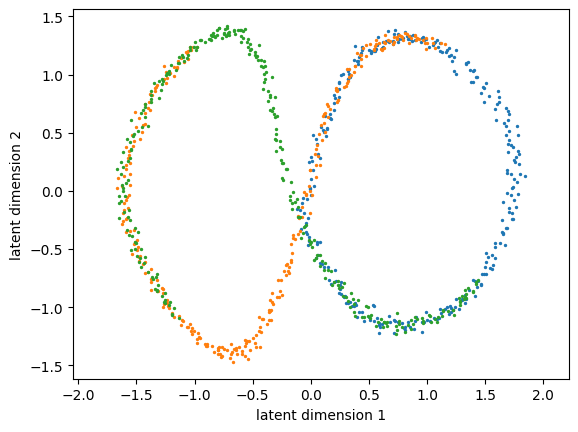

In [ ]:
for k in range(num_clusters):
    cur_data = data[labels == k]
    transformed = recognition_net(cur_data)[0].detach()
    plt.scatter(transformed[:, 0], transformed[:, 1], s=2)

plt.axis("equal")
plt.xlabel("latent dimension 1")
plt.ylabel("latent dimension 2")

## 2.3 Generate new data using the decoder and the generative model we just trained.

For this, we simply generate 1500 latent variables in the latent space from the prior and pass it through the decoder network.


In [ ]:
num_samples = 1500
samples = torch.randn(num_samples, 2)
transformed = decoder_net(samples)[0].detach()


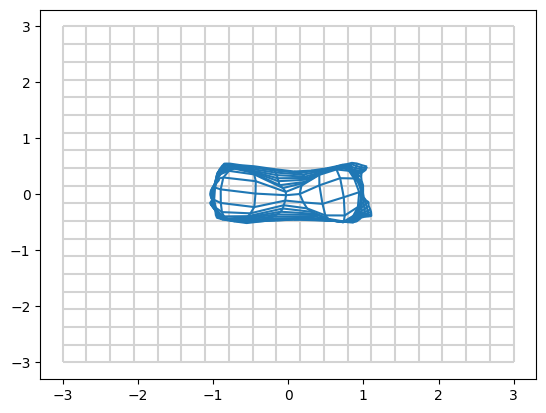

In [ ]:
from matplotlib.collections import LineCollection

def plot_grid(x,y, ax=None, **kwargs):
    ax = ax or plt.gca()
    segs1 = np.stack((x,y), axis=2)
    segs2 = segs1.transpose(1,0,2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()

def f(x,y):
    xy = torch.stack([x.flatten(), y.flatten()], dim=1)
    return decoder_net(xy)

fig, ax = plt.subplots()

grid_x,grid_y = torch.meshgrid(torch.linspace(-3,3,20),torch.linspace(-3,3,20))
plot_grid(grid_x,grid_y, ax=ax,  color="lightgrey")

distx, disty = f(grid_x,grid_y)
distx, disty = distx.reshape(20, 20, 2), disty.reshape(20, 20, 2)
plot_grid(distx[:, :, 0].detach().numpy(), distx[:, :, 1].detach().numpy(), ax=ax, color="C0")

plt.show()

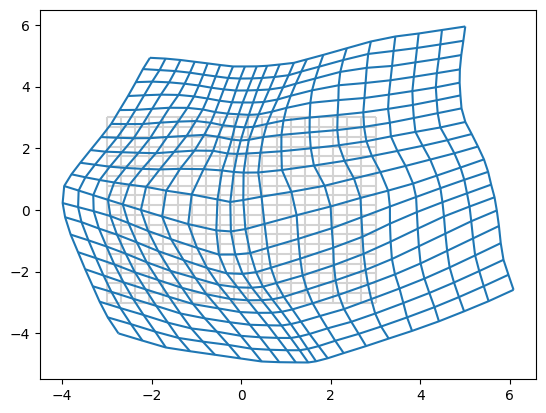

In [ ]:
def f(x,y):
    xy = torch.stack([x.flatten(), y.flatten()], dim=1)
    return recognition_net(xy)

fig, ax = plt.subplots()

grid_x,grid_y = torch.meshgrid(torch.linspace(-3,3,20),torch.linspace(-3,3,20))
plot_grid(grid_x,grid_y, ax=ax,  color="lightgrey")

distx, disty = f(grid_x,grid_y)
distx, disty = distx.reshape(20, 20, 2), disty.reshape(20, 20, 2)
plot_grid(distx[:, :, 0].detach().numpy(), distx[:, :, 1].detach().numpy(), ax=ax, color="C0")

plt.show()